In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

In [2]:
dataset = pd.read_csv(r"./Datasets/raw/FTSE.csv")
df = dataset.reset_index(drop=True)
df.shape[0]

1516

In [3]:
df

,date,close,open,high,low,vol,return
0,2012/1/3,5699.91,5572.28,5699.91,5572.28,778.53,0.0229
1,2012/1/4,5668.45,5699.91,5719.83,5646.36,696.94,-0.0055
2,2012/1/5,5624.26,5668.45,5689.33,5614.38,794.28,-0.0078
3,2012/1/6,5649.68,5624.26,5682.78,5623.36,705.02,0.0045
4,2012/1/9,5612.26,5649.68,5673.82,5604.62,785.65,-0.0066
...,...,...,...,...,...,...,...
1511,2017/12/21,7603.98,7525.22,7609.69,7517.88,640.56,0.0105
1512,2017/12/22,7592.66,7603.98,7614.40,7585.47,251.37,-0.0015
1513,2017/12/27,7620.68,7592.66,7632.71,7586.42,472.51,0.0037
1514,2017/12/28,7622.88,7620.68,7633.55,7609.77,321.52,0.0003


In [4]:
maxELevel = 21                           
maxTP = 1                
maxTS = 4096             
nTP = 0                    
p3 = 1.0 / 3.0          

stime = 0
etime = 0
Gstime = 0
Getime = 0
tlapse = 0
Gtlapse = 0

day = df.shape[0]

DT_DT= np.zeros((day,1))

DT_OP= np.zeros((day,1))
DT_HI= np.zeros((day,1))
DT_LO= np.zeros((day,1))
DT_CL= np.zeros((day,1))
DT_VL= np.zeros((day,1))
DT_RT= np.zeros((day,1))


Q= np.zeros((100,1))
NQ= np.zeros((100,1))
r= np.zeros((100,1))


QFEL = np.zeros((21,1))       
QPR = np.zeros((21,1))       
NQPR = np.zeros((21,1))      
K = np.zeros((21,1))


ALL_Pos_QPL = np.zeros((day,21))
ALL_Neg_QPL = np.zeros((day,21))

In [5]:
print("Printout ALL K values K0 .. K20 for first 20 Energy Levels")
for eL in range(0,21):    
    K[eL] = math.pow((1.1924 + (33.2383 * eL) + (56.2169 * eL * eL)) / (1 + (43.6106 * eL)), p3)
    print("Energy Level ",eL, " K",eL, " = ", K[eL])      

Printout ALL K values K0 .. K20 for first 20 Energy Levels
Energy Level  0  K 0  =  [1.06041043]
Energy Level  1  K 1  =  [1.2665998]
Energy Level  2  K 2  =  [1.4911995]
Energy Level  3  K 3  =  [1.66349934]
Energy Level  4  K 4  =  [1.80609901]
Energy Level  5  K 5  =  [1.92919156]
Energy Level  6  K 6  =  [2.03832293]
Energy Level  7  K 7  =  [2.13688129]
Energy Level  8  K 8  =  [2.22710524]
Energy Level  9  K 9  =  [2.31055991]
Energy Level  10  K 10  =  [2.38838747]
Energy Level  11  K 11  =  [2.46144992]
Energy Level  12  K 12  =  [2.53041565]
Energy Level  13  K 13  =  [2.59581465]
Energy Level  14  K 14  =  [2.65807505]
Energy Level  15  K 15  =  [2.71754825]
Energy Level  16  K 16  =  [2.77452666]
Energy Level  17  K 17  =  [2.82925649]
Energy Level  18  K 18  =  [2.88194724]
Energy Level  19  K 19  =  [2.93277882]
Energy Level  20  K 20  =  [2.98190702]


In [6]:
DT_DT = df['date']     
DT_OP = df['open']
DT_HI = df['high']
DT_LO = df['low']
DT_CL = df['close']
TSsize = df.shape[0]

TSsize

1516

In [7]:
# Calculate return.

for d in range (0,TSsize - 2):
    if (DT_CL[d + 1] > 0):
        DT_RT[d] = DT_CL[d] / DT_CL[d + 1]          
    else:
        DT_RT[d] = 1     
        
DT_RT

array([[1.00555002],
       [1.00785703],
       [0.99550063],
       ...,
       [0.9997114 ],
       [0.        ],
       [0.        ]])

In [8]:
# Get the maximum time series number of the return.

maxRno = TSsize - 2

In [9]:
# Calculate mean.

mu = 0
for d in range(0,maxRno):
    mu = mu + DT_RT[d]

mu = mu / maxRno

In [10]:
mu

array([0.99984509])

In [11]:
# Calculate standard deviation.

In [12]:
sigma = 0
for d in range(0,maxRno):
    sigma = sigma + (DT_RT[d] - mu) * (DT_RT[d] - mu)
    
sigma = math.sqrt((sigma/ maxRno))
sigma


0.008615814298444595

In [13]:
dr = 3 * sigma/ 50
dr

0.0005169488579066756

In [14]:
# Loop over all r from (r-50*dr) to (r+50*dr) and get the distribution function.
# Reset all the Q[] first.
auxR = 0

In [15]:
# Loop over the maxRno to get the distribution.

tQno = 0
num = 0

In [16]:
for nR in range (0,maxRno):    
    bFound = False
    nQ = 0
    # Get the start position of the wave function.
    auxR = 1 - (dr * 50)
    # Get the total number of the returns in each range of each segment of the wave function.
    while((bFound == False) and (nQ < 100)):
        
        if ((DT_RT[nR] > auxR) and (DT_RT[nR] <= (auxR + dr))):
            
            Q[nQ] = Q[nQ] + 1
            tQno= tQno + 1
            bFound = True
        else:
            num = num+1
            nQ = nQ + 1
            auxR = auxR + dr           

In [17]:
# Get the start position of the wave function.
auxR = 1 - (dr * 50)

In [18]:
# Normalize the wave function.
for nQ in range(0,100):
    r[nQ] = auxR
    NQ[nQ] = Q[nQ] / tQno        
    auxR = auxR + dr 

In [19]:
# Find the max value and its corresponding return in the wave function.

maxQ = 0
maxQno = 0


In [20]:
for nQ in range(0,100):     
    if (NQ[nQ] > maxQ):
        maxQ = NQ[nQ]
        maxQno = nQ 
maxQno

48

In [21]:
dr

0.0005169488579066756

In [22]:
# Compute the lambda value.
for i in range(0,day):     
    r0 = r[maxQno] - (dr / 2)
    r1 = r0 + dr
    rn1 = r0 - dr

rn1

array([0.99819068])

In [23]:
for i in range(0,day):  
    Lup = (pow(rn1, 2) * NQ[maxQno - 1]) - (pow(r1, 2) * NQ[maxQno + 1])
    Ldw = (pow(rn1, 4) * NQ[maxQno - 1]) - (pow(r1, 4) * NQ[maxQno + 1])

In [24]:
L = abs(Lup / Ldw)

In [25]:
# Use the Cardano's to compute the 21 Quantum Finance Energy Level. 
for eL in range(0,21):
    p = -1 * pow((2 * eL + 1), 2)
    q = -1 * L * pow((2 * eL + 1), 3) * pow(K[eL], 3)
    u = pow((-0.5 * q + np.sqrt(((q * q / 4.0) + (p * p * p / 27.0)))), p3)
    v = pow((-0.5 * q - np.sqrt(((q * q / 4.0) + (p * p * p / 27.0)))), p3)
    QFEL[eL] = u + v
        
QFEL

array([[  1.34666392],
       [  4.49575575],
       [  8.38986732],
       [ 12.75618644],
       [ 17.50483476],
       [ 22.57982394],
       [ 27.94219118],
       [ 33.56294095],
       [ 39.41948745],
       [ 45.49364316],
       [ 51.77038657],
       [ 58.23706072],
       [ 64.88282722],
       [ 71.69828008],
       [ 78.67516433],
       [ 85.80616541],
       [ 93.08474837],
       [100.50503258],
       [108.06169262],
       [115.74987873],
       [123.56515215]])

In [26]:
# Evaluate all QPR values.
for eL in range(0,21):
# Compute the QPR.  
    QPR[eL] = QFEL[eL] / QFEL[0]
#Compute the NQPR.
    NQPR[eL] = 1 + 0.21 * sigma * QPR[eL]         

NQPR

array([[1.00180932],
       [1.00604031],
       [1.01127227],
       [1.01713868],
       [1.02351876],
       [1.0303373 ],
       [1.03754195],
       [1.04509376],
       [1.05296237],
       [1.06112335],
       [1.06955651],
       [1.07824487],
       [1.08717384],
       [1.09633079],
       [1.10570464],
       [1.11528555],
       [1.12506475],
       [1.13503433],
       [1.14518714],
       [1.15551667],
       [1.16601694]])

In [27]:
QPLdata = pd.DataFrame(columns=["Date", "Open", "High", "Low", "Close", "QPLp1", "QPLp2", "QPLp3", "QPLp4", "QPLp5", "QPLp6", "QPLp7", "QPLp8",
      "QPLp9", "QPLp10", "QPLp11", "QPLp12", "QPLp13", "QPLp14", "QPLp15", "QPLp16", "QPLp17", "QPLp18", "QPLp19", "QPLp20", "QPLp21", "QPLn1", "QPLn2",
      "QPLn3", "QPLn4", "QPLn5", "QPLn6", "QPLn7", "QPLn8", "QPLn9", "QPLn10", "QPLn11", "QPLn12", "QPLn13", "QPLn14", "QPLn15", "QPLn16",
      "QPLn17", "QPLn18", "QPLn19", "QPLn20", "QPLn21"])

In [28]:
DT_DT

0         2012/1/3
1         2012/1/4
2         2012/1/5
3         2012/1/6
4         2012/1/9
           ...    
1511    2017/12/21
1512    2017/12/22
1513    2017/12/27
1514    2017/12/28
1515    2017/12/29
Name: date, Length: 1516, dtype: object

In [29]:
for d in range(0,TSsize):
    for eL in range(0,21):
        ALL_Pos_QPL[d][eL] = DT_OP[d] * NQPR[eL]
        ALL_Neg_QPL[d][eL] = DT_OP[d] / NQPR[eL]      
ALL_Pos_QPL.shape

(1516, 21)

In [30]:
print(DT_OP[d], DT_HI[d], DT_LO[d], DT_CL[d],
             ALL_Pos_QPL[0], ALL_Pos_QPL[1], ALL_Pos_QPL[2], ALL_Pos_QPL[3], ALL_Pos_QPL[4],
             ALL_Pos_QPL[5], ALL_Pos_QPL[6], ALL_Pos_QPL[7], ALL_Pos_QPL[8], ALL_Pos_QPL[9],
             ALL_Pos_QPL[10], ALL_Pos_QPL[11], ALL_Pos_QPL[12], ALL_Pos_QPL[13], ALL_Pos_QPL[14],
             ALL_Pos_QPL[15], ALL_Pos_QPL[16], ALL_Pos_QPL[17], ALL_Pos_QPL[18], ALL_Pos_QPL[19], ALL_Pos_QPL[20],
             ALL_Neg_QPL[0], ALL_Neg_QPL[1], ALL_Neg_QPL[2], ALL_Neg_QPL[3], ALL_Neg_QPL[4],
             ALL_Neg_QPL[5], ALL_Neg_QPL[6], ALL_Neg_QPL[7], ALL_Neg_QPL[8], ALL_Neg_QPL[9],
             ALL_Neg_QPL[10], ALL_Neg_QPL[11], ALL_Neg_QPL[12], ALL_Neg_QPL[13], ALL_Neg_QPL[14],
             ALL_Neg_QPL[15], ALL_Neg_QPL[16], ALL_Neg_QPL[17], ALL_Neg_QPL[18], ALL_Neg_QPL[19], ALL_Neg_QPL[20])

7622.88 7697.62 7620.01 7687.77 [5582.36204324 5605.9382892  5635.09226038 5667.78149886 5703.33311408
 5741.32793923 5781.4742722  5823.55503279 5867.40112828 5912.87639452
 5959.86837022 6008.28229684 6058.03703067 6109.06215226 6161.29585906
 6214.68338946 6269.17581831 6324.72911923 6381.30342248 6438.86241947
 6497.37287863] [5710.22296688 5734.33921375 5764.16094056 5797.59890802 5833.96481338
 5872.82988904 5913.89575162 5956.94034883 6001.79071495 6048.30756708
 6096.37586806 6145.89868897 6196.79302754 6248.98685139 6302.41694244
 6357.02728478 6412.76783266 6469.59355129 6527.46365776 6586.34101182
 6646.19162078] [5678.70604564 5702.68918565 5732.34631486 5765.59972528 5801.7649132
 5840.41547753 5881.25468179 5924.06169928 5968.66451894 6014.92462663
 6062.72762014 6111.97710551 6162.59053861 6214.49628464 6267.63147442
 6321.94040123 6377.37329555 6433.88537114 6491.43607018 6549.98845744
 6609.50872782] [5634.43609174 5658.23226443 5687.65819312 5720.65236721 5756.5356192

In [31]:
QPLdata.Date= DT_DT

In [32]:
QPLdata

,Date,Open,High,Low,Close,QPLp1,QPLp2,QPLp3,QPLp4,QPLp5,...,QPLn12,QPLn13,QPLn14,QPLn15,QPLn16,QPLn17,QPLn18,QPLn19,QPLn20,QPLn21
0,2012/1/3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012/1/4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012/1/5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012/1/6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/1/9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,2017/12/21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1512,2017/12/22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1513,2017/12/27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1514,2017/12/28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
QPLdata.Open= DT_OP

In [34]:
QPLdata

,Date,Open,High,Low,Close,QPLp1,QPLp2,QPLp3,QPLp4,QPLp5,...,QPLn12,QPLn13,QPLn14,QPLn15,QPLn16,QPLn17,QPLn18,QPLn19,QPLn20,QPLn21
0,2012/1/3,5572.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012/1/4,5699.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012/1/5,5668.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012/1/6,5624.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/1/9,5649.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,2017/12/21,7525.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1512,2017/12/22,7603.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1513,2017/12/27,7592.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1514,2017/12/28,7620.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
QPLdata.High= DT_HI
QPLdata.Low = DT_LO
QPLdata.Close = DT_CL

qplv = QPLdata.values
qplv

array([['2012/1/3', 5572.28, 5699.91, ..., nan, nan, nan],
       ['2012/1/4', 5699.91, 5719.83, ..., nan, nan, nan],
       ['2012/1/5', 5668.45, 5689.33, ..., nan, nan, nan],
       ...,
       ['2017/12/27', 7592.66, 7632.71, ..., nan, nan, nan],
       ['2017/12/28', 7620.68, 7633.55, ..., nan, nan, nan],
       ['2017/12/29', 7622.88, 7697.62, ..., nan, nan, nan]], dtype=object)

In [36]:
for d in range(0,TSsize - 2):
    for eL in range(0,21):
        qplv[d][eL+5] = ALL_Pos_QPL[d][eL]
        qplv[d][eL+26] = ALL_Neg_QPL[d][eL]

In [37]:
qplv

array([['2012/1/3', 5572.28, 5699.91, ..., 4865.824792002026,
        4822.327668394375, 4778.901408063005],
       ['2012/1/4', 5699.91, 5719.83, ..., 4977.273825109339,
        4932.780423876364, 4888.359509003927],
       ['2012/1/5', 5668.45, 5689.33, ..., 4949.802332658065,
        4905.554507653976, 4861.378768930266],
       ...,
       ['2017/12/27', 7592.66, 7632.71, ..., 6630.060453753598,
        6570.7922779744085, 6511.620658858431],
       ['2017/12/28', 7620.68, 7633.55, ..., nan, nan, nan],
       ['2017/12/29', 7622.88, 7697.62, ..., nan, nan, nan]], dtype=object)

In [38]:
QPLdata = pd.DataFrame(qplv,columns=["Date", "Open", "High", "Low", "Close", "QPLp1", "QPLp2", "QPLp3", "QPLp4", "QPLp5", "QPLp6", "QPLp7", "QPLp8",
      "QPLp9", "QPLp10", "QPLp11", "QPLp12", "QPLp13", "QPLp14", "QPLp15", "QPLp16", "QPLp17", "QPLp18", "QPLp19", "QPLp20", "QPLp21", "QPLn1", "QPLn2",
      "QPLn3", "QPLn4", "QPLn5", "QPLn6", "QPLn7", "QPLn8", "QPLn9", "QPLn10", "QPLn11", "QPLn12", "QPLn13", "QPLn14", "QPLn15", "QPLn16",
      "QPLn17", "QPLn18", "QPLn19", "QPLn20", "QPLn21"])

In [39]:
QPLdata

,Date,Open,High,Low,Close,QPLp1,QPLp2,QPLp3,QPLp4,QPLp5,...,QPLn12,QPLn13,QPLn14,QPLn15,QPLn16,QPLn17,QPLn18,QPLn19,QPLn20,QPLn21
0,2012/1/3,5572.28,5699.91,5572.28,5699.91,5582.362043,5605.938289,5635.09226,5667.781499,5703.333114,...,5167.917029,5125.472862,5082.663038,5039.573672,4996.280977,4952.852703,4909.349288,4865.824792,4822.327668,4778.901408
1,2012/1/4,5699.91,5719.83,5646.36,5668.45,5710.222967,5734.339214,5764.160941,5797.598908,5833.964813,...,5286.285318,5242.868991,5199.078632,5155.002328,5110.718037,5066.295063,5021.795226,4977.273825,4932.780424,4888.359509
2,2012/1/5,5668.45,5689.33,5614.38,5624.26,5678.706046,5702.689186,5732.346315,5765.599725,5801.764913,...,5257.108272,5213.931577,5170.382913,5126.549883,5082.510015,5038.332228,4994.078002,4949.802333,4905.554508,4861.378769
3,2012/1/6,5624.26,5682.78,5623.36,5649.68,5634.436092,5658.232264,5687.658193,5720.652367,5756.535619,...,5216.125003,5173.284903,5130.075735,5086.584418,5042.887875,4999.054488,4955.14526,4911.214753,4867.311875,4823.48052
4,2012/1/9,5649.68,5673.82,5604.62,5612.26,5659.902085,5683.805809,5713.364734,5746.508032,5782.553466,...,5239.700353,5196.666628,5153.262168,5109.574283,5065.680244,5021.648743,4977.541058,4933.411998,4889.310692,4845.281233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,2017/12/21,7525.22,7609.69,7517.88,7603.98,7538.835539,7570.674649,7610.046333,7654.192304,7702.203841,...,6979.138268,6921.818518,6864.004958,6805.813884,6747.348219,6688.699459,6629.949222,6571.170516,6512.428775,6453.782734
1512,2017/12/22,7603.98,7614.4,7585.47,7592.66,7617.738041,7649.910384,7689.694137,7734.302146,7782.816178,...,7052.1829,6994.263234,6935.844589,6877.04448,6817.966905,6758.704318,6699.339193,6639.945301,6580.588761,6521.328923
1513,2017/12/27,7592.66,7632.71,7586.42,7620.68,7606.397559,7638.522007,7678.246535,7722.788136,7771.229946,...,7041.684357,6983.850916,6925.519239,6866.806664,6807.817038,6748.642675,6689.365927,6630.060454,6570.792278,6511.620659
1514,2017/12/28,7620.68,7633.55,7609.77,7622.88,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df1 = pd.DataFrame(QPLdata)
df1.to_csv("./Datasets/FTSE/FTSE_QPL.csv",index = True)

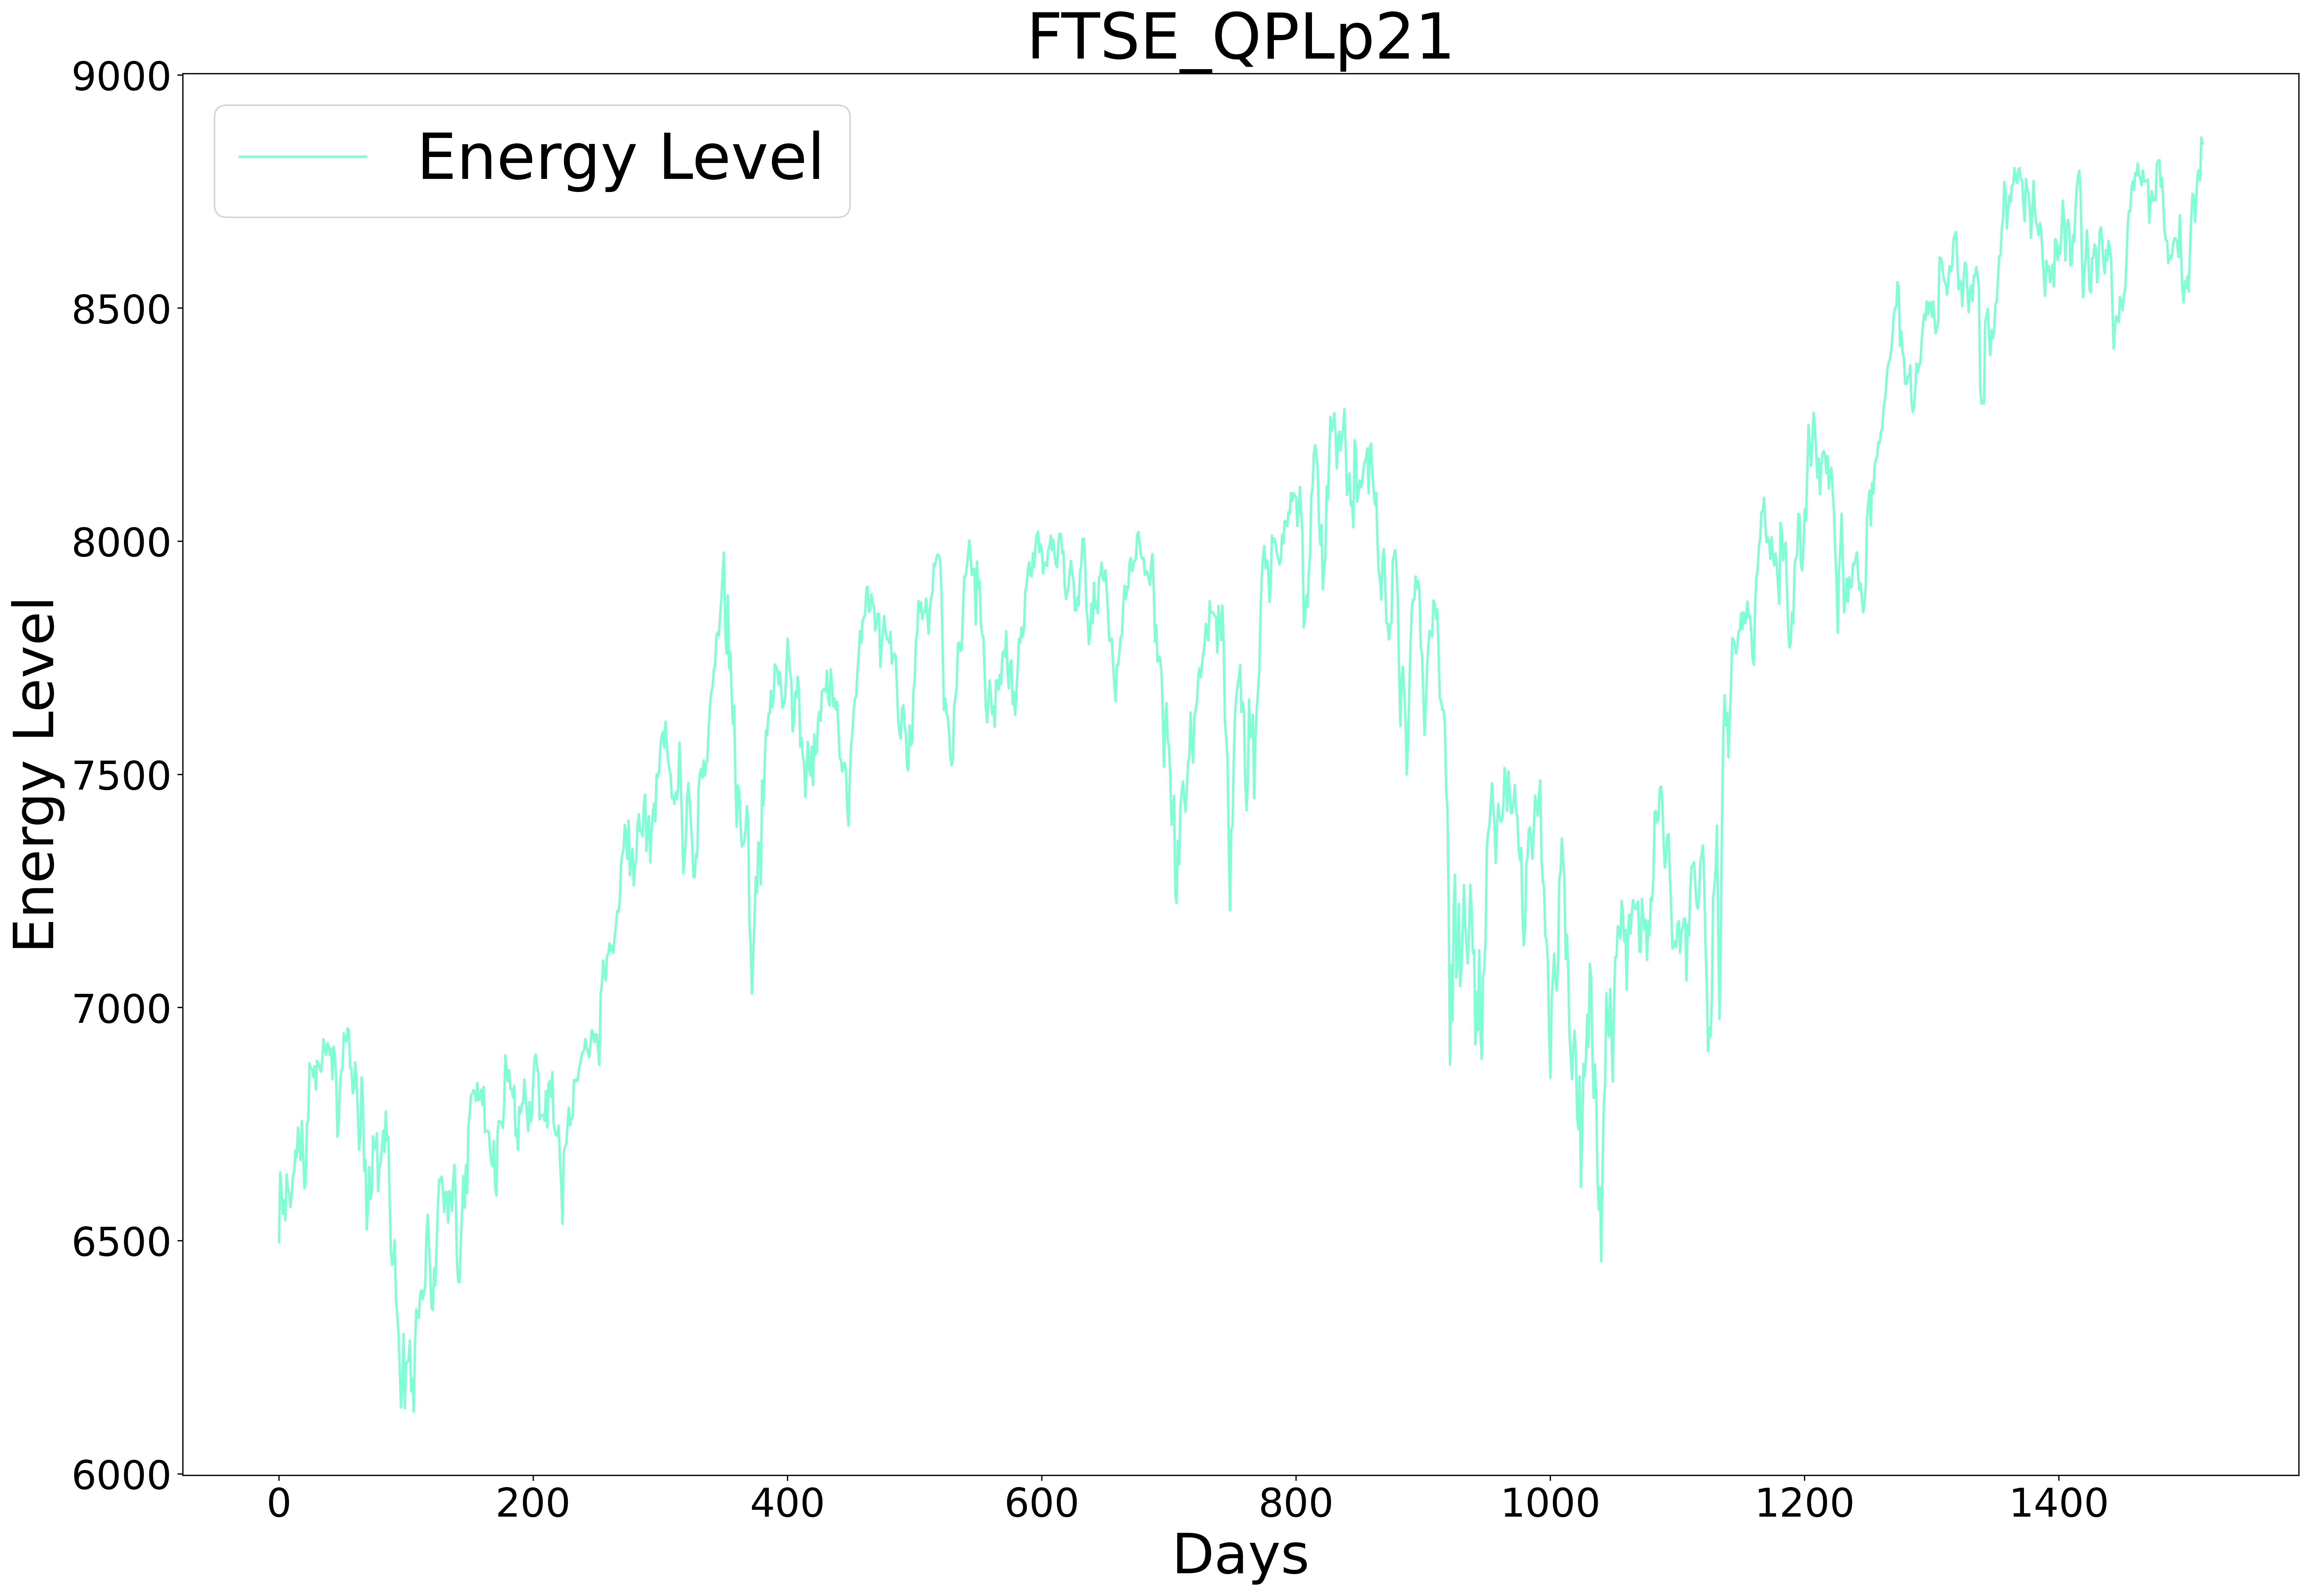

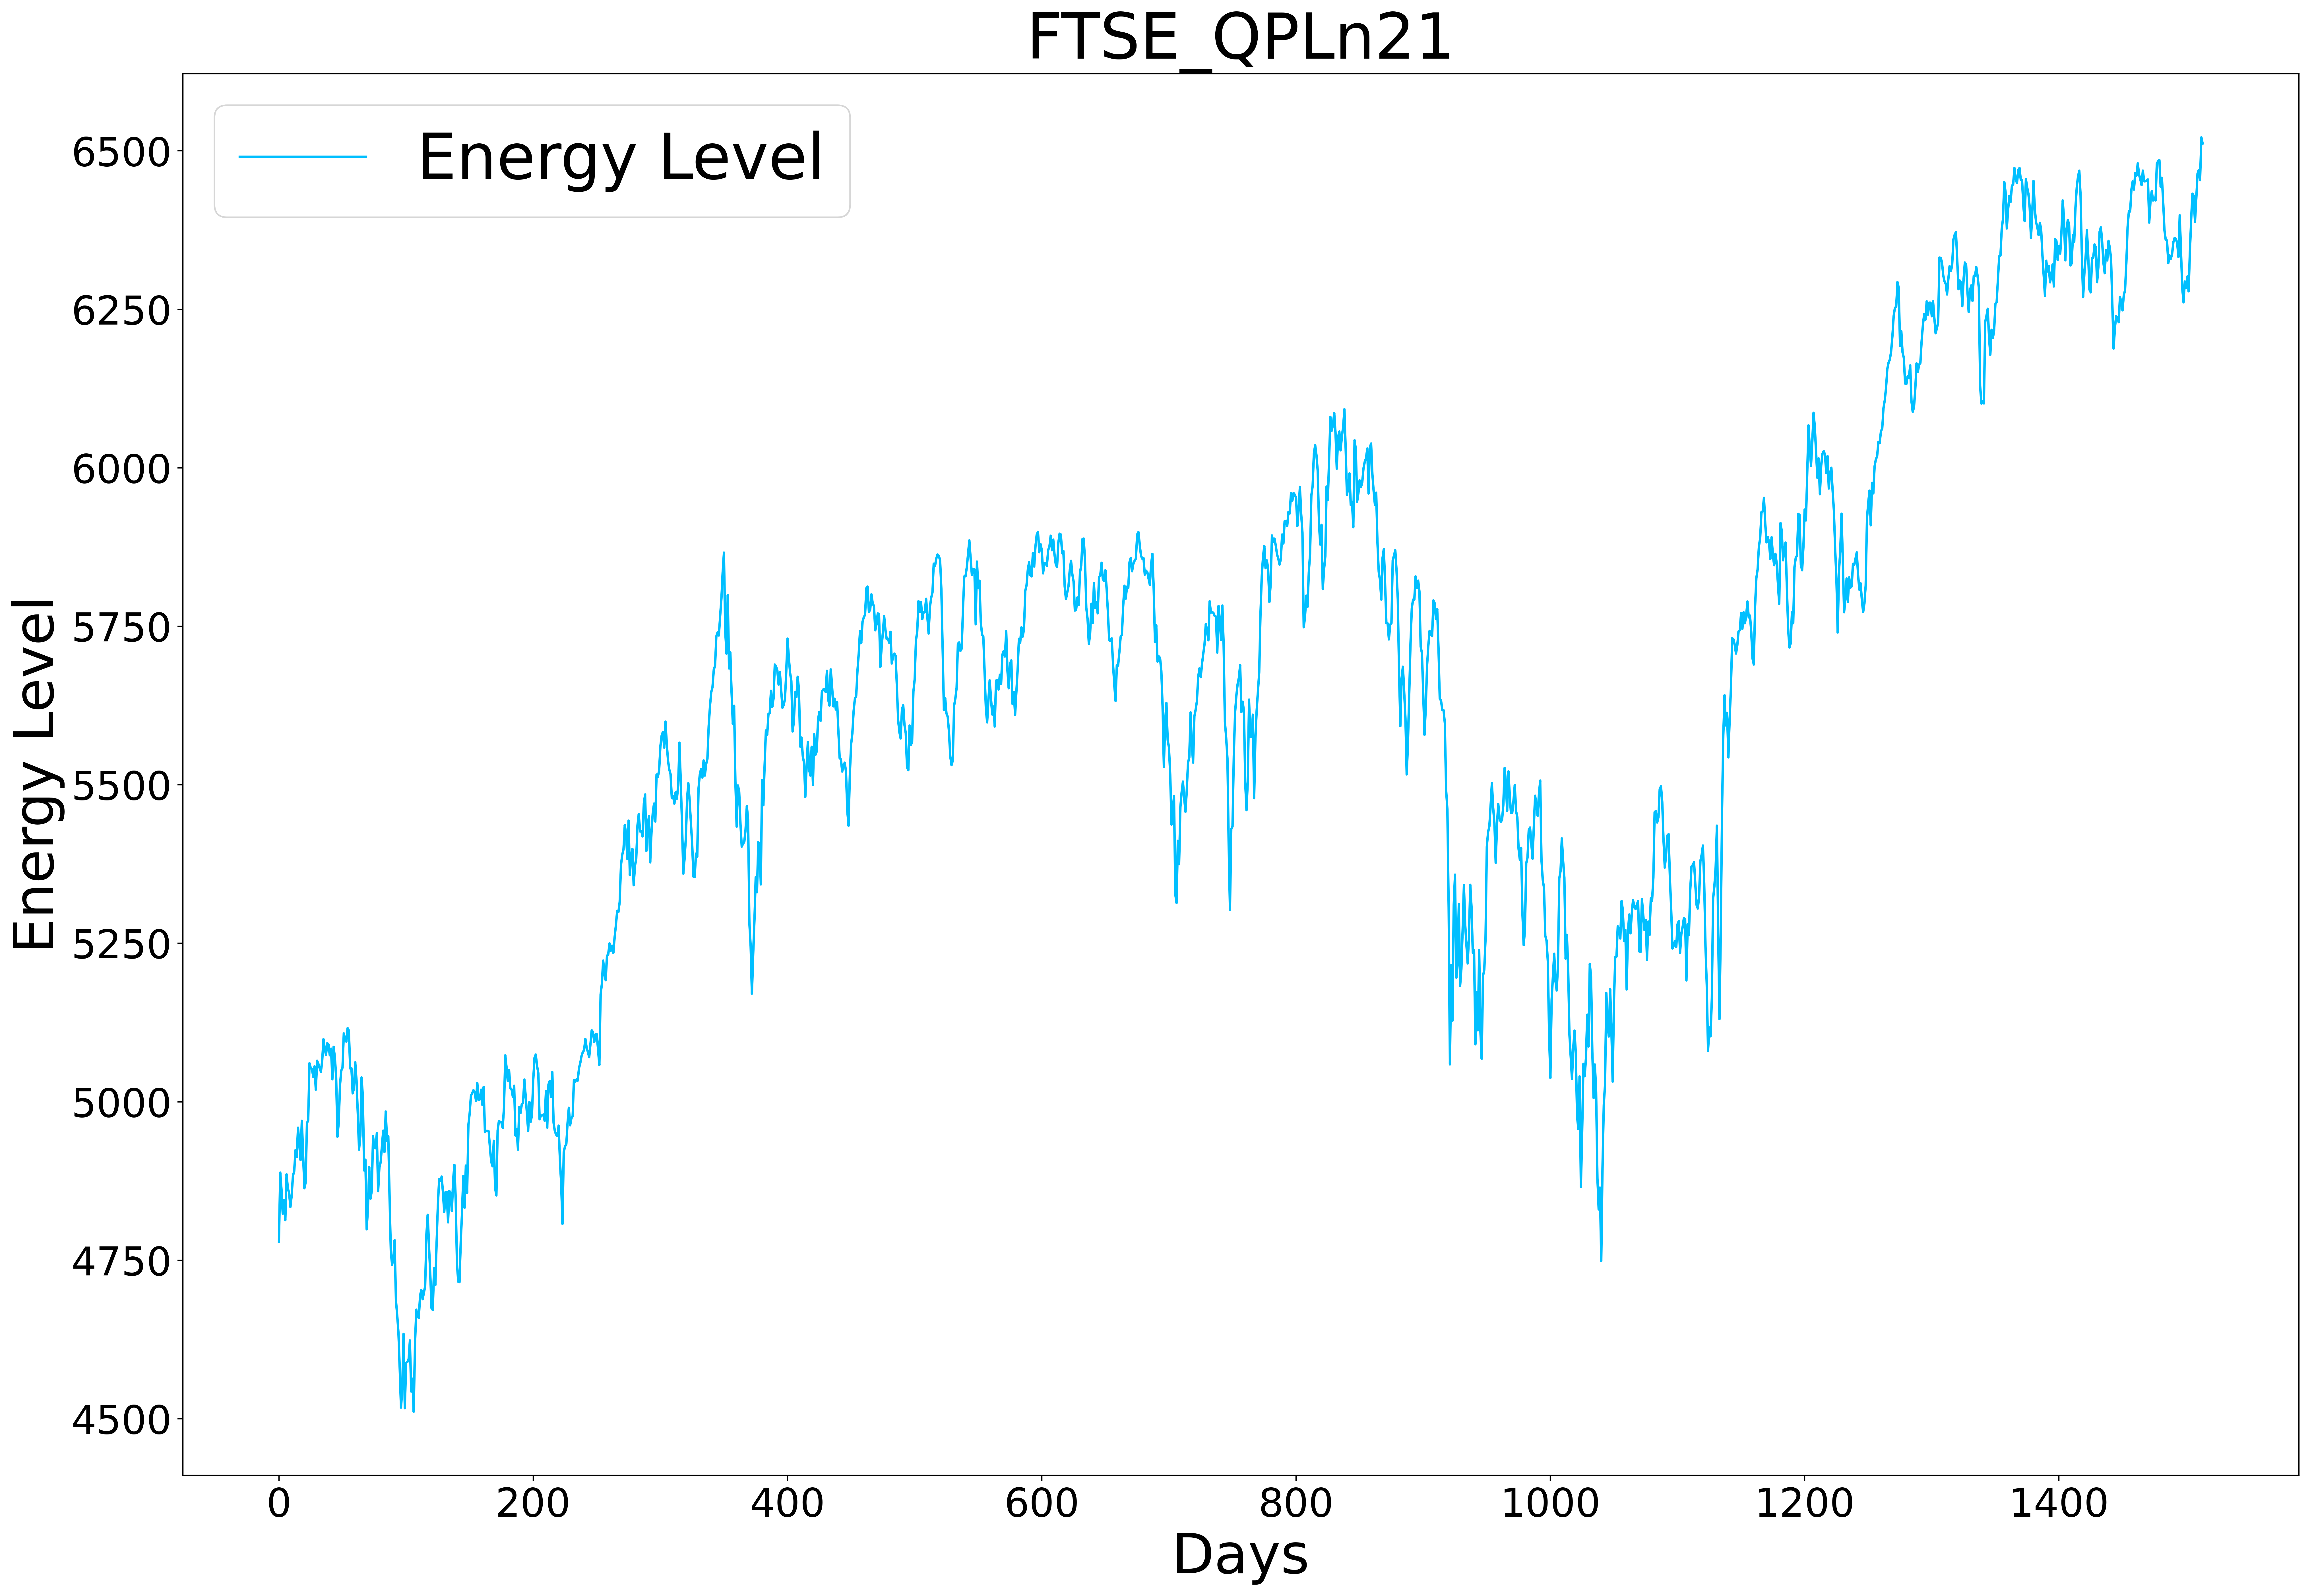

In [41]:
qplp21 = QPLdata["QPLp21"]
qpln21 = QPLdata["QPLn21"]

plt.figure(figsize=(24, 16), dpi=400)
plt.plot(qplp21,color='aquamarine')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('Energy Level', fontsize=35)
plt.title('FTSE_QPLp21', fontsize=40)
plt.legend(['Energy Level'],fontsize=40)
plt.savefig('./pic/FTSE_pic/FTSE_QPLp21.png')
plt.show()

plt.figure(figsize=(24, 16), dpi=400)
plt.plot(qpln21,color='deepskyblue')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('Energy Level', fontsize=35)
plt.title('FTSE_QPLn21', fontsize=40)
plt.legend(['Energy Level'],fontsize=40)
plt.savefig('./pic/FTSE_pic/FTSE_QPLn21.png')
plt.show()